In [1]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

In [2]:
#定义了六种网络结构
__all__ = ['ResNet','resnet18','resnet34','resnet50','resnet100','resnet152']

In [3]:
#每种网络都有训练好的可以直接用的.pth参数文件
model_urls = {'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',   
'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',   
'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth', 
'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',}

In [4]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [5]:
#ResNet中大多使用3*3的卷积定义如下
#卷积步长stride=1,扩张大小dliation=1(padding),in_plance,out_plance输入输出通道数，
#groups是分组卷积参数，groups=1等于没有分组
'''函数继承自nn网络中的2维卷积，参数由原来的6个变成了3个，输入图与输出图长宽保持一致'''
def conv3x3(in_planes, 
            out_planes, 
            stride=1,
            groups=1, 
            dilation=1):
    """3x3 convolution with padding"""   
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,# 滤波器（过滤器）大小为3*3
                     stride=stride,
                     padding=dilation,#0填充一层
                     bias=False,
                     groups=groups)

In [6]:
#ResNet 残差模块，似乎用了两个3*3卷积，卷积后使用了BN和ReLU
#super(BasicBlock, self).__init__() 神经网络的类都继承自torch.nn.Module 
#__init()__ 和 forward() 是自定义类的两个主要函数
class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']
    
    def __init__(self,inplanes,planes,stride=1,downsample=None,groups=1,base_width=64,
                 dilation=1,norm_layer=None):
        super(BasicBlock,self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d # 批标准化层
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError('Dilation > 1 not supported in BasicBlock')
        self.conv1 = conv3x3(inplanes,planes,stride)# 3*3卷积层
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes,planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample# 这个是shortcut的操作
        self.stride = stride
        
        def forward(self,x):
            identity = x# 获得上一层的输出
            
            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)
            
            out = self.conv2(out)
            out = self.bn2(out)
            
            if self.downsample is not None:# 当shortcut存在的时候
                identity = self.downsample(x)
                # 将上一层的输出x输入进这个downsample所拥有一些操作（卷积等），将结果赋给residual# 
                #目的就是为了应对上下层输出输入深度不一致问题
                
            out += identity# 将bn2的输出和shortcut过来加在一起
            out = self.relu(out)
            
            return out

In [7]:
#Bottleneck 模块
'''
这里有三个卷积，分别是1 * 1，3 * 3， 1* 1大小的卷积核，分别用于压缩维度，卷积处理
恢复维度
inplanes 是输入通道数，planes是输出通道数，expansion是输出通道数的倍乘。

在使用Bottleneck时，它先对通道数进行压缩，在放大，所以传入的参数planes不是实际输出的
通道数，而是block内部压缩后的通道数，真正的输出通道数为planes*expansion
目的是使用Bottleneck结构可以减少网络参数数量。
'''
class Bottleneck(nn.Module):
    expansion = 4# 若我们输入深度为64，那么扩张4倍后就变为了256
    # 其目的在于使得当前块的输出深度与下一个块的输入深度保持一致
    
    def __init__(self, inplanes,planes,stride,downsample=None,groups=1,
                base_width = 64 , dilation =1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        
        self.conv1 = conv1x1(inplanes,width) # 这层1*1卷积层，是为了降维，把输出深度降到与3*3卷积层的输入深度一致
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width,width,stride,groups,dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width,planes*self.expansion)
        self.bn3 = norm_layer(planes*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
        def forward(self, x):
            identity = x
            
            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)
            
            out = self.conv2(out)
            out = self.bn2(out)
            out = self.relu(out)
            
            out = self.conv3(out)
            out = self.bn3(out)
            
            if self.downsample is not None:
                identity  = self.downsample(x)
                
            out += identity
            out = self.relu(out)
            
            return out

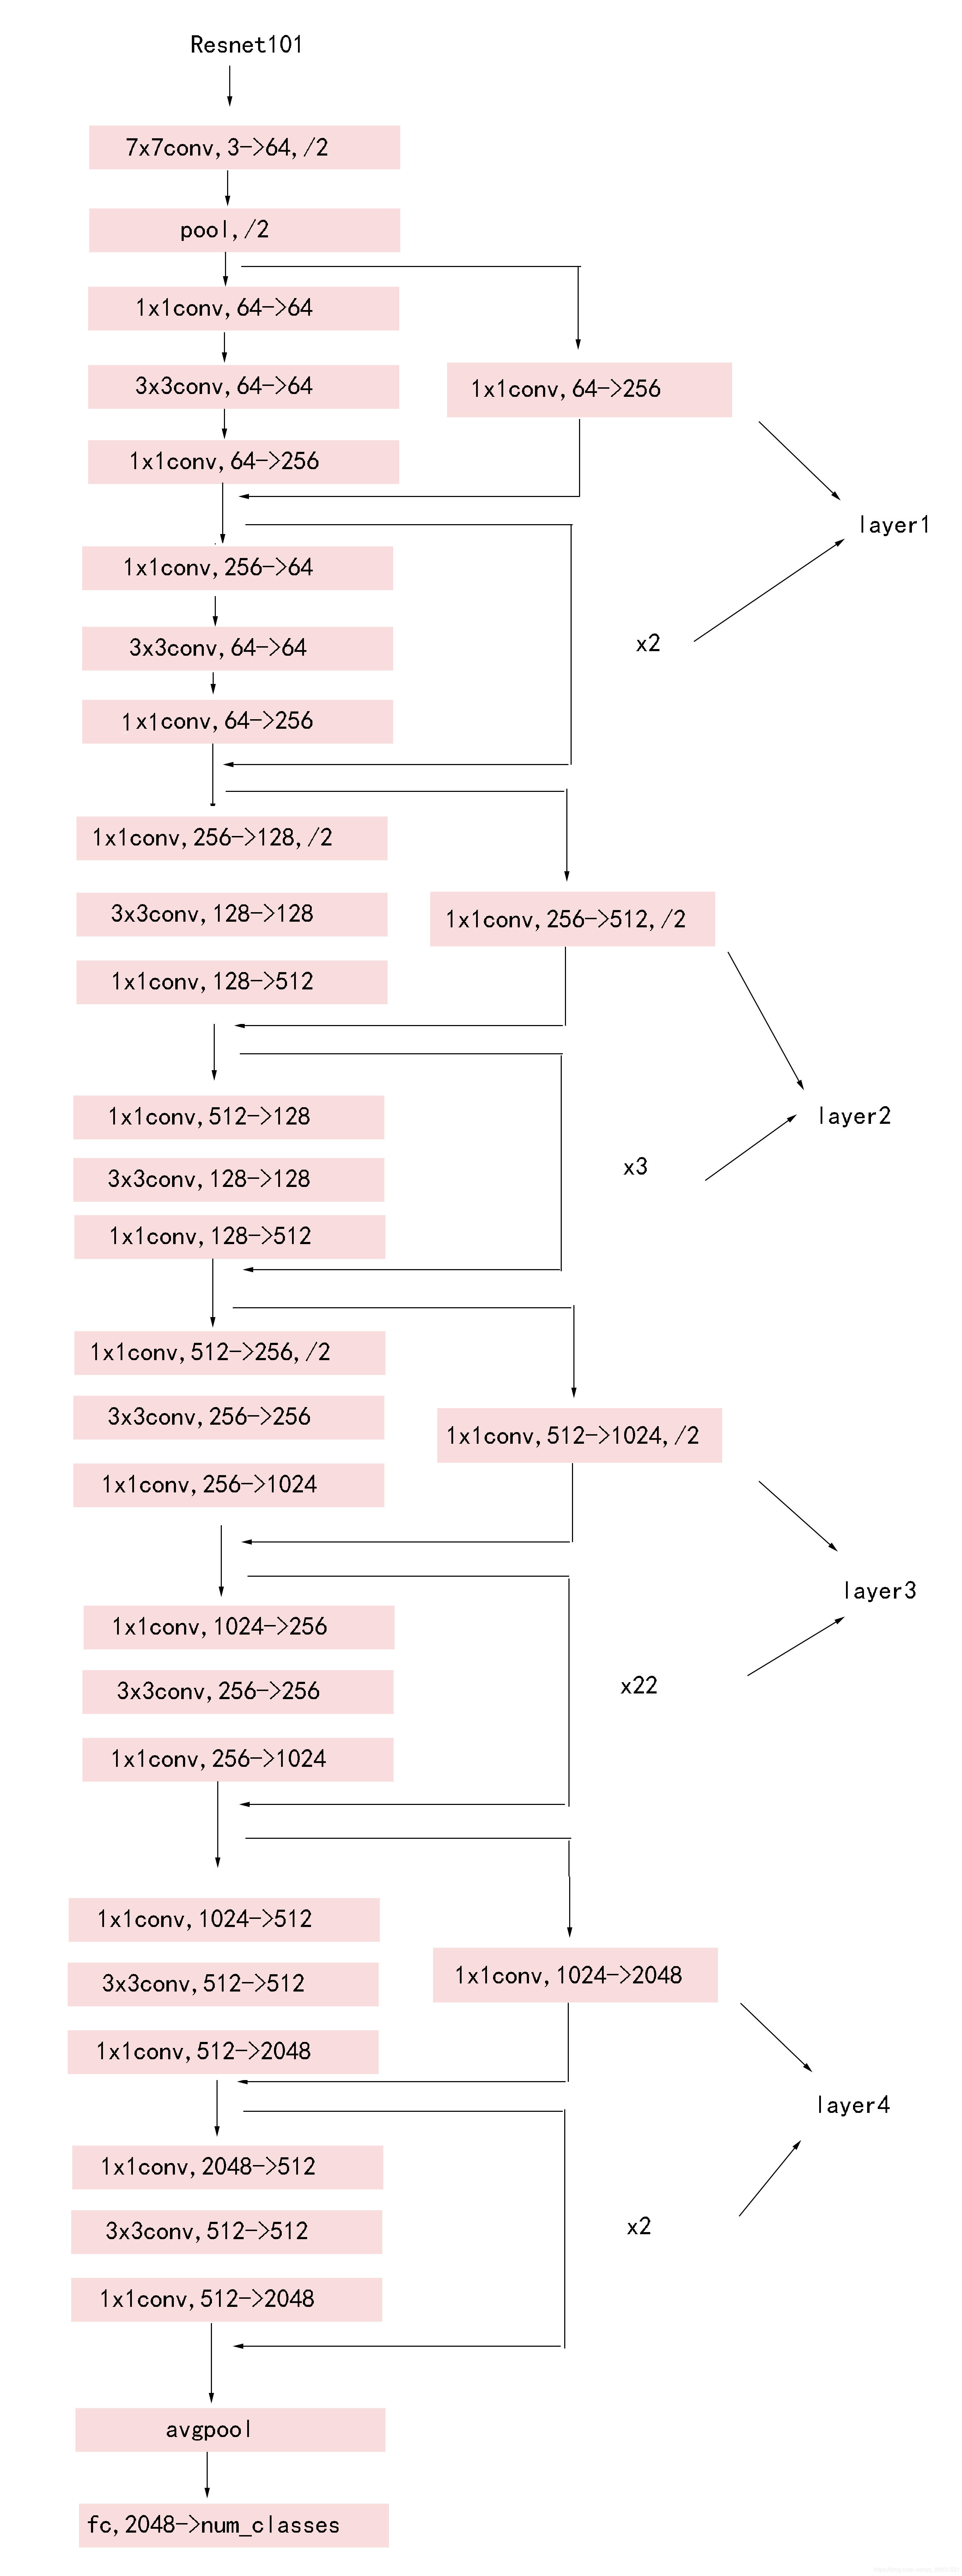

In [29]:
'''
ResNet 共有五个阶段，其中第一阶段为一个 7*7 的卷积，stride = 2，padding = 3，然后经过 BN、ReLU 和 maxpooling，
此时特征图的尺寸已成为输入的 1/4,
接下来是四个阶段，也就是代码中 layer1，layer2，layer3，layer4。
这里用 _make_layer 函数产生四个 Layer，需要用户输入每个 layer 的 block 数目（ 即layers列表 )以及采用的 block 类型,
基础版 BasicBlock 还是 Bottleneck 版）
_make_layer 方法的第一个输入参数 block 选择要使用的模块是 BasicBlock还是 Bottleneck 类，
第二个输入参数 planes 是该模块的输出通道数，第三个输入参数 blocks 是每个 blocks 中包含多少个 residual 子结构。'''

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                groups = 1, width_per_group=64,replace_stride_with_dilation=None,
                norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
            self._norm_layer = norm_layer
            
            self.inplanes = 64
            self.dilation = 1
            if replace_stride_with_dilation is None:
                replace_stride_with_dilation = [False,False,False]
            if len(replace_stride_with_dilation) != 3:
                raise("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
            self.groups = groups
            self.base_width = width_per_group
            self.conv1 = nn.Conv2d(3,self.inplanes,kernel_size=7,stride=2,padding=3,
                                  bias=False)
            self.bn1 = norm_layer(self.inplanes)
            self.relu = nn.ReLU(inplace = True)
            self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
            self.layer1 = self._make_layer(block,64,layers[0])
            self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
            self.layer3 = self._make_layer(block,256,layers[2], stride=2,
                                          dilate=replace_stride_with_dilation[1])
            self.layer4 = self._make_layer(block,512,layers[3],stride=2,
                                          dilate=replace_stride_with_dilation[2])
            self.avgpool = nn.AdaptiveAvgPool2d((1,1))
            self.fc = nn.Linear(512*block.expansion,num_classes)
            
            for m in self.modules():
                if isinstance(m,nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
            if zero_init_residual:
                for m in self.modules():
                    if isinstance(m, Bottleneck):
                        nn.init.constant_(m.bn3.weight, 0)
                    elif isinstance(m, BasicBlock):
                        nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
               nn.Conv2d(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer,stride=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



In [30]:
'''
pretrained 参数默认是 False，**kwargs 可以将不定数量的参数传递给一个函数，对应的还有 *args，
用于传递非键值对的可变数量的参数列表，而 **kwargs 允许将一个不定长度的键值对作为参数传递给一个函数。
如果参数 pretrained 是 True，那么会通过 model_zoo.py 中的 load_url 函数根据上面 model_urls 字典下载或导入相应的预训练模型。

'''


def resnet101(pretrained=False,**kwargs):
    model = ResNet(Bottleneck,[3,4,23,3],**kwargs)
	# block对象为 瓶颈块Bottleneck
    # layers列表 [3,4,23,3]
    # 这表示layer1、layer2、layer3、layer4分别由3、4、23、3个Bottleneck组成
    
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))

    return model

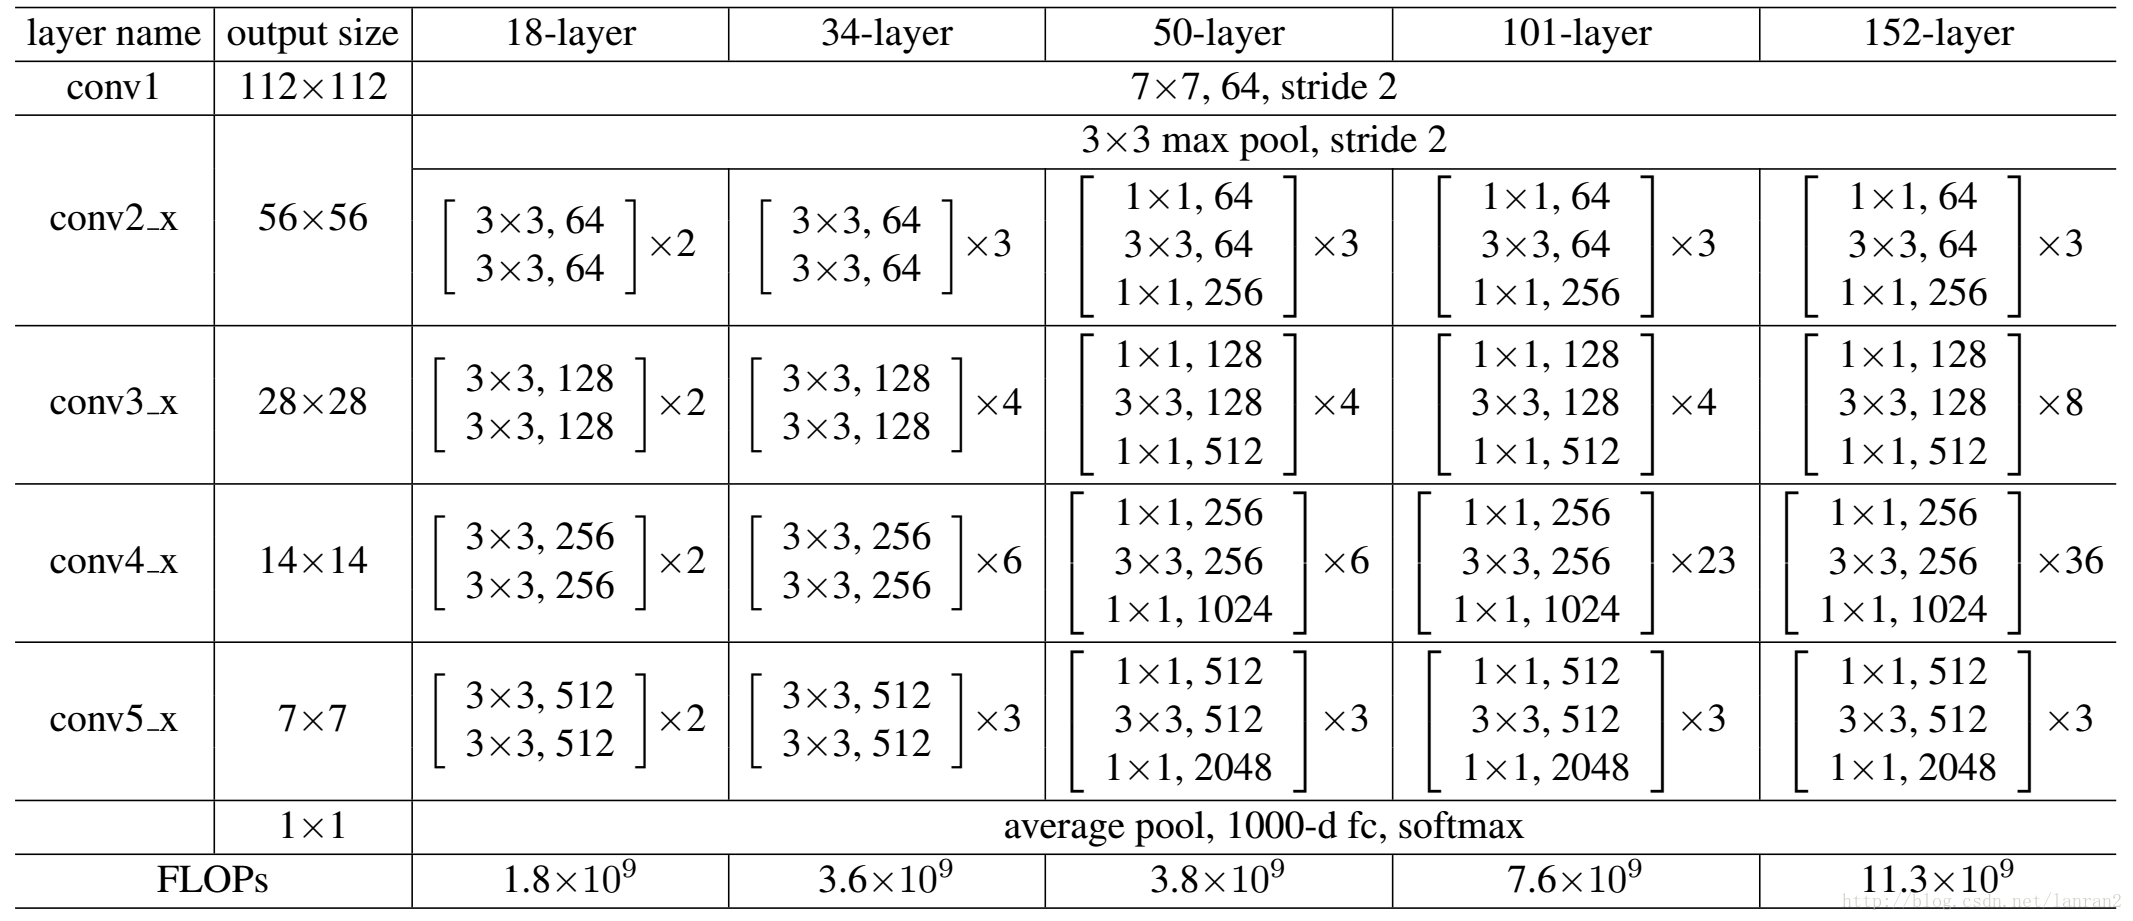

In [31]:
resnet101()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 